### Imports

In [ ]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re
import shap
import pickle

sys.path.append("../")
pl.Config.set_tbl_rows(50)

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa

# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

/Users/konstantinburkin/Documents/hse_projects/parse-records/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### constants

In [18]:
FILES_DIR = "../data"

### select data

In [19]:
# os.path.join(FILES_DIR, path)

In [20]:
path = "data_for_models"
os.makedirs(os.path.join(FILES_DIR, path), exist_ok=True)
file_name = "imputed_labeled_data.parquet"
file_path = os.path.join(FILES_DIR, path, file_name)
labeled_data = pl.read_parquet(file_path)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "numerical_cols.pickle"), "rb"
) as f:
    numerical_cols = pickle.load(f)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "discrete_cols.pickle"), "rb"
) as f:
    discrete_cols = pickle.load(f)

In [21]:
labeled_data["target"].value_counts().sort("count")

target,count
i32,u32
1,473
0,518
-1,6289


In [22]:
labeled_data.sample(2)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_K29,disease_I83,disease_I49,disease_I48,disease_K86,disease_U07,disease_D50,disease_I70,disease_J42,disease_N28,disease_I45,disease_I35,disease_N40,disease_E06,disease_E66,disease_J44,disease_I11,disease_I67,disease_E04,disease_K25,disease_I69,disease_B18,disease_J45,disease_E11,disease_G93,disease_C34,disease_I34,disease_I25,disease_I63,disease_E03,disease_K80,disease_E74,disease_E10,disease_L40,disease_I50,disease_H90,disease_M42,disease_D64,disease_N20,disease_M10,disease_I44,disease_C50,disease_I71,disease_I64,disease_N18,disease_K26,disease_C61,disease_C18,disease_I47,bmi
datetime[ms],i64,str,i64,i64,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
2021-09-05 00:00:00,0,"""62F52333-46C2-4E30-A8AE-B5E4BF…",0,0,-1,1,0,0,3.735546,4.126291,3.1307,114.429059,53.182588,60.998345,53.723573,1.310167,3.446596,0.452006,82.0,60.0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.61895
2020-03-26 00:00:00,1,"""E837C0A2-BEC0-4947-8D3C-4E6FC8…",0,0,1,2,0,0,3.2,3.9,3.1,120.0,50.0,70.0,58.0,1.3,3.4,0.2,60.0,76.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.894054


## model with known target

### split data

In [7]:
known_target = labeled_data.filter(c("target") != -1)

In [8]:
discrete_cols_without_main_disease = list(
    set(discrete_cols) - set(["main_disease_I21"])
)

In [9]:
# sorted(discrete_cols_without_main_disease)

discrete_cols_cut = [
    "condition_status",
    "final_table1_gospitalization_result",
    "final_table1_main_desease_status",
    "gender",
    "gospitalisation_delivery",
    "gospitalisation_type",
    "main_disease_I21",
]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    known_target.select(discrete_cols_cut + numerical_cols),
    known_target["target"],
    test_size=0.2,
    random_state=2,
)

X_train_cut, X_eval, y_train_cut, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

In [188]:
# cat_cols = X_train.select(
#     pl.selectors.by_dtype(pl.String),
# ).columns

### catboost

In [190]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)

model.fit(
    X=X_train.to_pandas(),
    y=y_train.to_pandas(),
    early_stopping_rounds=50,
    verbose=5,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

metric = roc_auc_score(y_test, model.predict_proba(X_test.to_pandas())[:, 1])
print(f"AUC Score (CatBoost): {metric:.3f}")

0:	test: 0.6803657	best: 0.6803657 (0)	total: 2.46ms	remaining: 612ms
5:	test: 0.7508744	best: 0.7508744 (5)	total: 10.3ms	remaining: 421ms
10:	test: 0.7521463	best: 0.7529412 (6)	total: 18.1ms	remaining: 394ms
15:	test: 0.7581081	best: 0.7581081 (15)	total: 24.7ms	remaining: 361ms
20:	test: 0.7582671	best: 0.7615262 (19)	total: 31.4ms	remaining: 343ms
25:	test: 0.7613672	best: 0.7615262 (19)	total: 38.4ms	remaining: 331ms
30:	test: 0.7650238	best: 0.7650238 (30)	total: 47.9ms	remaining: 339ms
35:	test: 0.7731320	best: 0.7739269 (34)	total: 55.5ms	remaining: 330ms
40:	test: 0.7758347	best: 0.7761526 (37)	total: 61.5ms	remaining: 314ms
45:	test: 0.7812401	best: 0.7812401 (45)	total: 68.2ms	remaining: 302ms
50:	test: 0.7823529	best: 0.7831479 (49)	total: 74.5ms	remaining: 291ms
55:	test: 0.7877583	best: 0.7877583 (55)	total: 80.1ms	remaining: 278ms
60:	test: 0.7920509	best: 0.7920509 (60)	total: 86ms	remaining: 267ms
65:	test: 0.7955485	best: 0.7955485 (65)	total: 91.5ms	remaining: 255ms

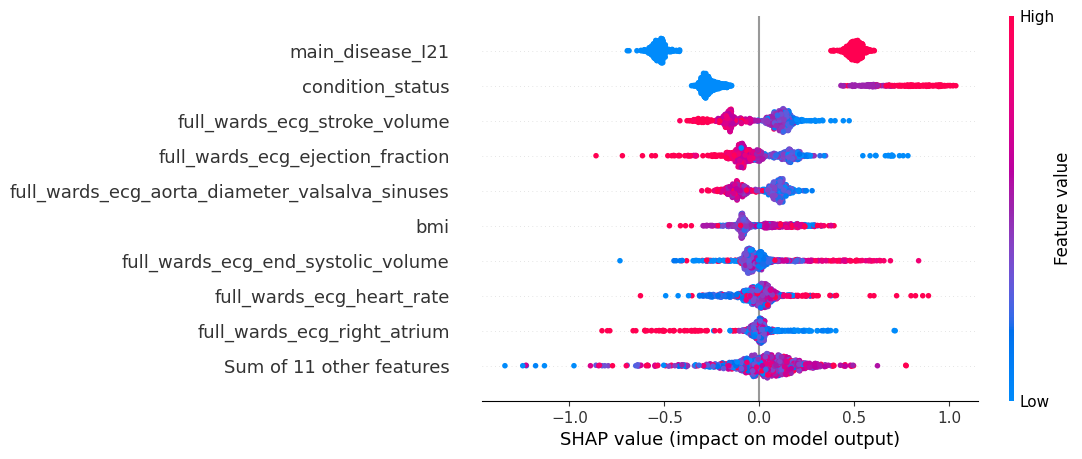

In [216]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train.to_pandas())
shap.plots.beeswarm(
    shap_values,
    plot_size=(8, 5),
)
plt.show()

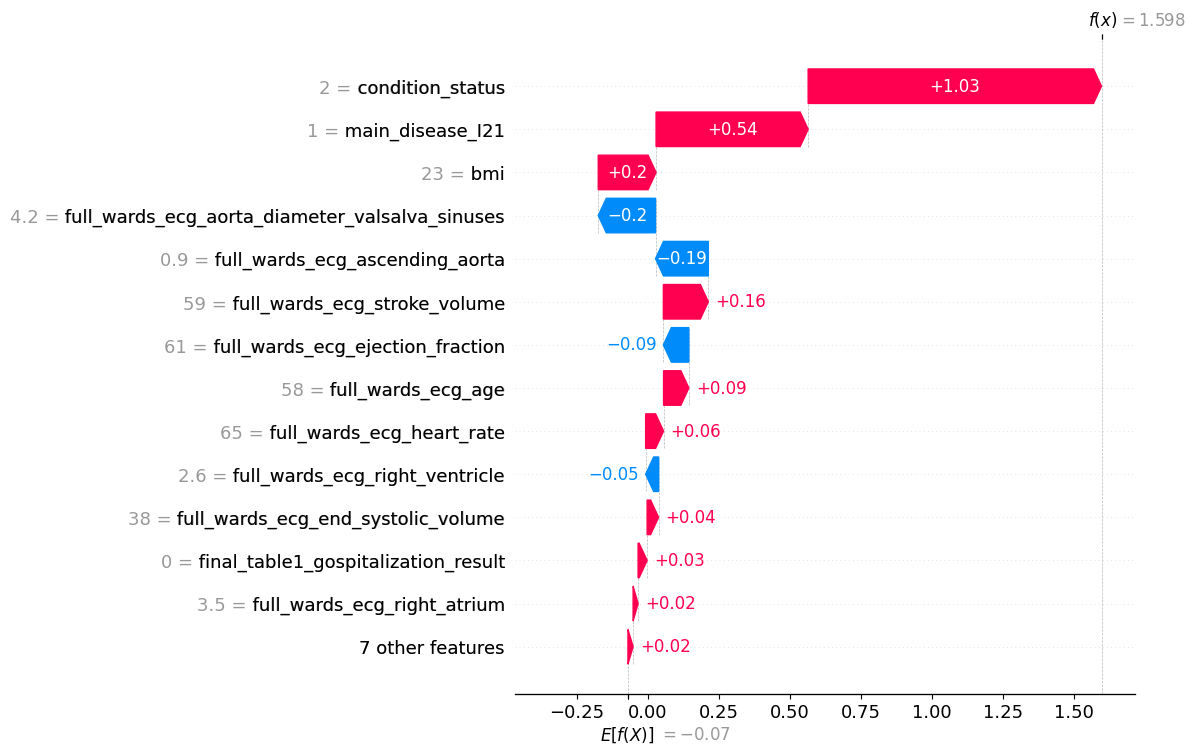

In [217]:
shap.plots.waterfall(shap_values[0], max_display=14)

/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_77485/1551176968.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


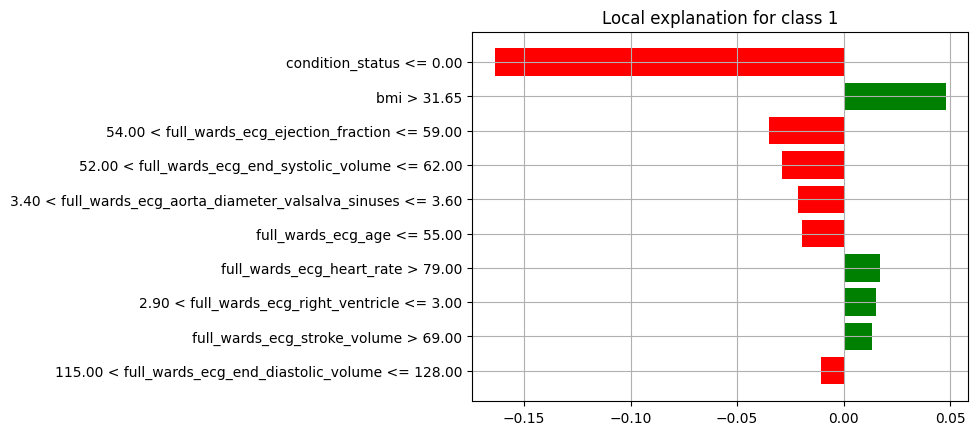

In [ ]:
import lime

import lime.lime_tabular

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_pandas().values,
    feature_names=X_train.columns,
    class_names=["0", "1"],
    mode="classification",
)


def lime_predict_fn(x):
    # x is a numpy array, shape (n, features)
    # Convert to DataFrame with correct columns and dtypes
    df = pd.DataFrame(x, columns=X_train.columns)
    # If you have categorical columns, cast them to the correct dtype
    for col in discrete_cols_cut:
        df[col] = df[col].astype(X_train[col].to_pandas().dtype)
    return model.predict_proba(df)


def explain_instance(instance, model, num_features=10):
    explanation = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=lime_predict_fn,
        # num_features=num_features,
    )
    return explanation


# Example usage: Explain the first instance in the test set
instance_to_explain = X_test.to_pandas().iloc[3]
explanation = explain_instance(instance_to_explain, model)
fig = explanation.as_pyplot_figure()
plt.grid()
fig.show()

### random forest

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 200, 800, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    #     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    # Train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        random_state=2024,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        #         criterion=criterion,
        n_jobs=-1,
    )
    rf_model.fit(X_train, y_train.to_pandas())

    # Evaluate the model
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

    return auc_score_rf


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and the corresponding AUC score
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

[I 2025-06-07 11:43:23,297] A new study created in memory with name: no-name-5fd8bf48-6acd-4bab-ab9a-3fb9ca784676
[I 2025-06-07 11:43:23,854] Trial 0 finished with value: 0.7948012232415902 and parameters: {'n_estimators': 400, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7948012232415902.
[I 2025-06-07 11:43:24,578] Trial 1 finished with value: 0.7953109072375127 and parameters: {'n_estimators': 600, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7953109072375127.
[I 2025-06-07 11:43:25,408] Trial 2 finished with value: 0.7982670744138632 and parameters: {'n_estimators': 800, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7982670744138632.
[I 2025-06-07 11:43:26,145] Trial 3 finished with value: 0.7985728848114169 and parameters: {'n_estimators': 700, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.

Best hyperparameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}
Best AUC score: 0.7998980632008156


In [155]:
study.best_params

{'n_estimators': 500,
 'max_depth': 8,
 'min_samples_split': 3,
 'min_samples_leaf': 2}

In [218]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=2024,
    n_estimators=500,
    max_depth=5,
    # **study.best_params,
)  # You can adjust hyperparameters as needed
rf_model.fit(X_train, y_train.to_pandas())

# Evaluate the model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

AUC Score (Random Forest): 0.793


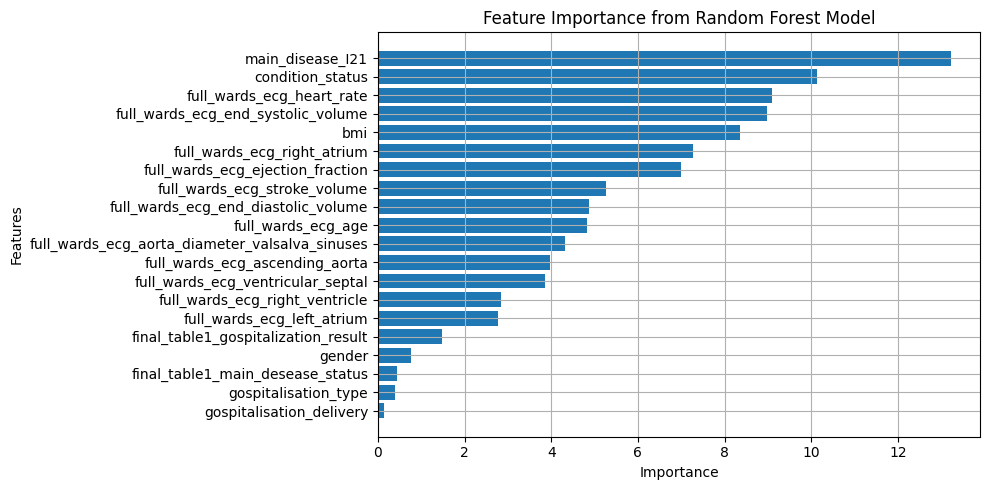

In [220]:
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"],
)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest Model")
plt.tight_layout()
plt.grid()
plt.show()

### linear regression

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_cols]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])
X_test_scaled = X_test.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(X_train_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_cols).to_pandas()),
#     columns=numerical_cols,
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)

X_train_pd = X_train.to_pandas().drop(columns=numerical_cols)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_cols)
X_test_pd = X_test.to_pandas().drop(columns=numerical_cols)

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)
logistic_model.fit(X_train_scaled_final, y_train.to_pandas())

# Evaluate the model
y_pred_proba = logistic_model.predict_proba(X_test_scaled_final)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score: {auc_score:.3f}")

AUC Score: 0.803


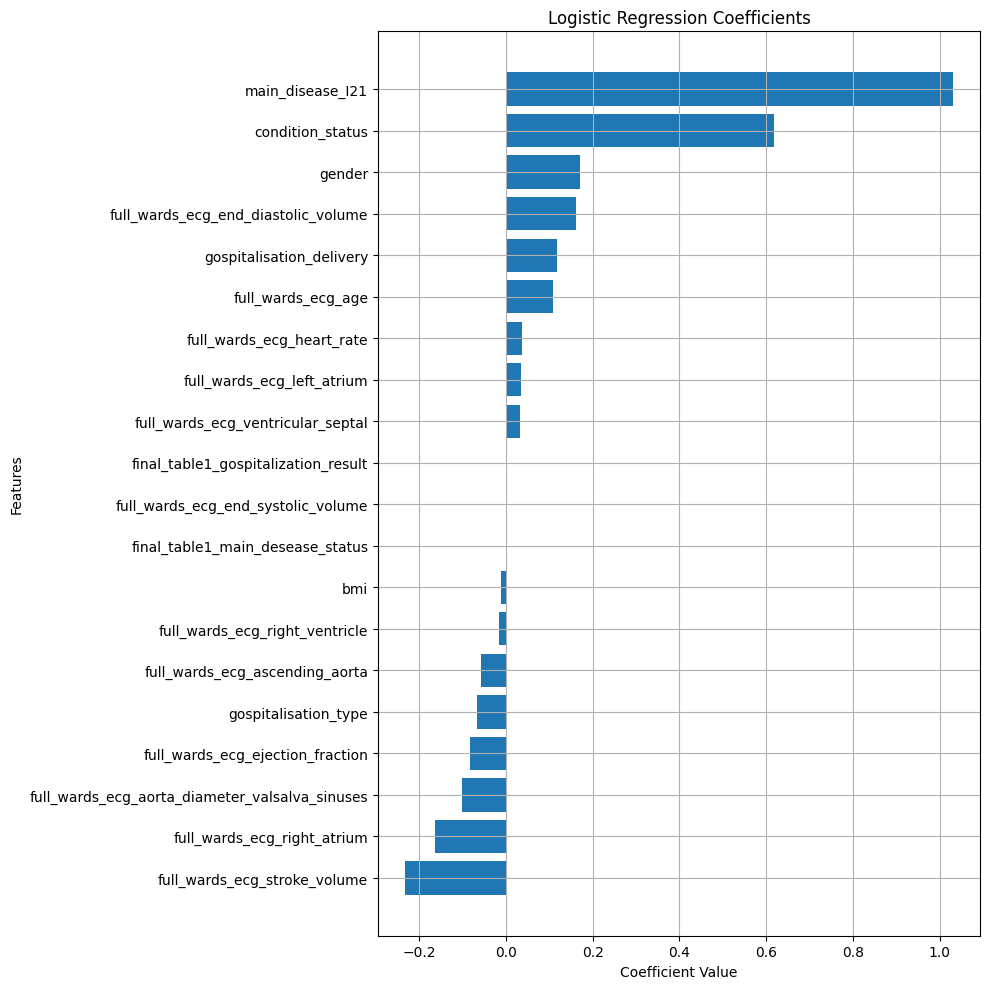

In [161]:
coefficients = pd.DataFrame(
    {
        "feature": X_train_scaled_final.columns,
        "coefficient": logistic_model.coef_[0],
    }
).sort_values("coefficient", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(
    coefficients["feature"],
    coefficients["coefficient"],
)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.grid()
plt.show()

### individual feature

In [133]:
roc_auc_score(y_test.to_pandas(), X_test["main_disease_I21"].to_pandas())

np.float64(0.7116717635066259)

## Semi supervised learning

### split data

In [144]:
known_target = labeled_data.filter(c("target") != -1)

In [145]:
# sorted(discrete_cols_without_main_disease)

discrete_cols_cut = [
    "condition_status",
    "final_table1_gospitalization_result",
    "final_table1_main_desease_status",
    "gender",
    "gospitalisation_delivery",
    "gospitalisation_type",
    "main_disease_I21",
]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(
    known_target.select(discrete_cols_cut + numerical_cols),
    known_target["target"],
    test_size=0.2,
    random_state=2,
)

In [147]:
X_train_cut, X_eval, y_train_cut, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

In [148]:
missing_target = labeled_data.filter(c("target") == -1)

In [149]:
X_train = pl.concat([X_train, missing_target.select(X_train.columns)])
y_train = pl.concat(
    [
        y_train.cast(pl.Int64),
        pl.Series("target", [-1] * missing_target.height).cast(pl.Int64),
    ]
)

In [150]:
# cat_cols = X_train.select(
#     pl.selectors.by_dtype(pl.String),
# ).columns

### log reg

In [167]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_cols]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])
X_test_scaled = X_test.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(X_train_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_cols).to_pandas()),
#     columns=numerical_cols,
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)

X_train_pd = X_train.to_pandas().drop(columns=numerical_cols)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_cols)
X_test_pd = X_test.to_pandas().drop(columns=numerical_cols)

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)


self_training_model = SelfTrainingClassifier(
    logistic_model,
    verbose=1,
    criterion="threshold",
    threshold=0.85,
    max_iter=5,
)

self_training_model.fit(X_train, y_train.to_pandas())

y_pred_proba = self_training_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score (SelfTrainingClassifier with RandomForest): {auc_score:.3f}")

End of iteration 1, added 289 new labels.
End of iteration 2, added 801 new labels.
End of iteration 3, added 638 new labels.
End of iteration 4, added 738 new labels.
End of iteration 5, added 703 new labels.
AUC Score (SelfTrainingClassifier with RandomForest): 0.808


In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_cols]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])
X_test_scaled = X_test.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(X_train_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_cols).to_pandas()),
#     columns=numerical_cols,
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)

X_train_pd = X_train.to_pandas().drop(columns=numerical_cols)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_cols)
X_test_pd = X_test.to_pandas().drop(columns=numerical_cols)

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)

logistic_model.fit(
    X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas()
)

# Evaluate the model
y_pred_proba_rf = logistic_model.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

AUC Score (Random Forest): 0.806


### random forest

In [62]:
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier

In [185]:
rf_model = RandomForestClassifier(
    random_state=2024,
    n_estimators=500,
    n_jobs=-1,
    verbose=0,
    max_depth=5,
)


self_training_model = SelfTrainingClassifier(
    rf_model,
    verbose=1,
    criterion="threshold",
    threshold=0.82,
    max_iter=5,
)

self_training_model.fit(X_train, y_train.to_pandas())

y_pred_proba = self_training_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score (SelfTrainingClassifier with RandomForest): {auc_score:.4f}")

End of iteration 1, added 3 new labels.
End of iteration 2, added 5 new labels.
End of iteration 3, added 23 new labels.
End of iteration 4, added 66 new labels.
End of iteration 5, added 79 new labels.
AUC Score (SelfTrainingClassifier with RandomForest): 0.7992


In [169]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=2024,
    n_estimators=500,
    n_jobs=-1,
    verbose=0,
    max_depth=5,
)
rf_model.fit(X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas())

# Evaluate the model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.4f}")

AUC Score (Random Forest): 0.7930


### catboost

In [173]:
model = CatBoostClassifier(
    random_seed=2024,
    # cat_features=[X_train.columns.index(col) for col in discrete_cols_cut],
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
    verbose=0,
)


self_training_model = SelfTrainingClassifier(
    model,
    verbose=1,
    criterion="threshold",
    threshold=0.85,
    max_iter=7,
)

self_training_model.fit(X_train.to_pandas(), y_train.to_pandas())

y_pred_proba = self_training_model.predict_proba(X_test.to_pandas())[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score (SelfTrainingClassifier with RandomForest): {auc_score:.3f}")

End of iteration 1, added 442 new labels.
End of iteration 2, added 1138 new labels.
End of iteration 3, added 1109 new labels.
End of iteration 4, added 724 new labels.
End of iteration 5, added 352 new labels.
End of iteration 6, added 99 new labels.
End of iteration 7, added 85 new labels.
AUC Score (SelfTrainingClassifier with RandomForest): 0.808


In [108]:
# Train CatBoostClassifier model
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)
# model.fit(X_train, y_train.to_pandas())

model.fit(
    X=X_train_cut.to_pandas(),
    y=y_train_cut.to_pandas(),
    early_stopping_rounds=50,
    verbose=5,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test.to_pandas())[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

0:	test: 0.6423688	best: 0.6423688 (0)	total: 2.04ms	remaining: 509ms
5:	test: 0.7195548	best: 0.7195548 (5)	total: 8.83ms	remaining: 359ms
10:	test: 0.7224960	best: 0.7243243 (6)	total: 14.4ms	remaining: 313ms
15:	test: 0.7124006	best: 0.7243243 (6)	total: 18.9ms	remaining: 276ms
20:	test: 0.7227345	best: 0.7243243 (6)	total: 25.3ms	remaining: 276ms
25:	test: 0.7157393	best: 0.7243243 (6)	total: 29.9ms	remaining: 257ms
30:	test: 0.7165342	best: 0.7243243 (6)	total: 35ms	remaining: 247ms
35:	test: 0.7136725	best: 0.7243243 (6)	total: 39.7ms	remaining: 236ms
40:	test: 0.7135135	best: 0.7243243 (6)	total: 45.8ms	remaining: 234ms
45:	test: 0.7106518	best: 0.7243243 (6)	total: 51.2ms	remaining: 227ms
50:	test: 0.7109698	best: 0.7243243 (6)	total: 56.5ms	remaining: 221ms
55:	test: 0.7100159	best: 0.7243243 (6)	total: 62.8ms	remaining: 217ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7243243243
bestIteration = 6

Shrink model to first 7 iterations.
AUC Score (Random 

In [128]:
# Train CatBoostClassifier model
model = CatBoostClassifier(
    random_seed=2024,
    # cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)
# model.fit(X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas())

model.fit(
    X=X_train.filter(y_train != -1).to_pandas(),
    y=y_train.filter(y_train != -1).to_pandas(),
    # early_stopping_rounds=50,
    verbose=5,
    # eval_set=(
    #     X_eval.to_pandas(),
    #     y_eval.to_pandas(),
    # ),
)

# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test.to_pandas())[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

0:	total: 919us	remaining: 229ms
5:	total: 4.54ms	remaining: 184ms
10:	total: 7.36ms	remaining: 160ms
15:	total: 10ms	remaining: 147ms
20:	total: 12.4ms	remaining: 135ms
25:	total: 14.7ms	remaining: 126ms
30:	total: 17.8ms	remaining: 126ms
35:	total: 20.3ms	remaining: 121ms
40:	total: 22.6ms	remaining: 115ms
45:	total: 25.2ms	remaining: 112ms
50:	total: 27.4ms	remaining: 107ms
55:	total: 29.5ms	remaining: 102ms
60:	total: 31.7ms	remaining: 98.2ms
65:	total: 33.9ms	remaining: 94.4ms
70:	total: 36.3ms	remaining: 91.6ms
75:	total: 38.5ms	remaining: 88.2ms
80:	total: 40.8ms	remaining: 85.1ms
85:	total: 43.2ms	remaining: 82.5ms
90:	total: 45.5ms	remaining: 79.5ms
95:	total: 47.8ms	remaining: 76.7ms
100:	total: 50ms	remaining: 73.8ms
105:	total: 52.3ms	remaining: 71.1ms
110:	total: 54.9ms	remaining: 68.8ms
115:	total: 57.7ms	remaining: 66.7ms
120:	total: 60ms	remaining: 64ms
125:	total: 62.2ms	remaining: 61.3ms
130:	total: 64.5ms	remaining: 58.6ms
135:	total: 66.7ms	remaining: 55.9ms
140:	to

In [143]:
labeled_data["target"].value_counts()

target,count
i32,u32
0,518
1,473
-1,6289


In [ ]:
# Train CatBoostClassifier model
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)
# model.fit(X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas())

model.fit(
    X=X_train.filter(y_train != -1).to_pandas(),
    y=y_train.filter(y_train != -1).to_pandas(),
    # early_stopping_rounds=50,
    verbose=5,
    # eval_set=(
    #     X_eval.to_pandas(),
    #     y_eval.to_pandas(),
    # ),
)

# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test.to_pandas())[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

0:	total: 1.62ms	remaining: 403ms
5:	total: 7.06ms	remaining: 287ms
10:	total: 13.9ms	remaining: 301ms
15:	total: 19.4ms	remaining: 284ms
20:	total: 24.3ms	remaining: 265ms
25:	total: 30.1ms	remaining: 260ms
30:	total: 34.9ms	remaining: 246ms
35:	total: 40ms	remaining: 238ms
40:	total: 45.2ms	remaining: 230ms
45:	total: 50ms	remaining: 222ms
50:	total: 55.5ms	remaining: 217ms
55:	total: 61ms	remaining: 211ms
60:	total: 66.7ms	remaining: 207ms
65:	total: 71.9ms	remaining: 200ms
70:	total: 77.8ms	remaining: 196ms
75:	total: 83.7ms	remaining: 192ms
80:	total: 90.2ms	remaining: 188ms
85:	total: 95.3ms	remaining: 182ms
90:	total: 100ms	remaining: 175ms
95:	total: 105ms	remaining: 169ms
100:	total: 110ms	remaining: 162ms
105:	total: 115ms	remaining: 156ms
110:	total: 120ms	remaining: 151ms
115:	total: 127ms	remaining: 147ms
120:	total: 133ms	remaining: 141ms
125:	total: 138ms	remaining: 136ms
130:	total: 143ms	remaining: 130ms
135:	total: 150ms	remaining: 126ms
140:	total: 156ms	remaining: 1

### individual feature

In [99]:
roc_auc_score(y_test.to_pandas(), X_test["main_disease_I21"].to_pandas())

0.7116717635066259

In [ ]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)

model.fit(
    X=X_train.to_pandas(),
    y=y_train.to_pandas(),
    early_stopping_rounds=50,
    verbose=5,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

metric = roc_auc_score(y_test, model.predict_proba(X_test.to_pandas())[:, 1])
print(f"AUC Score (Random Forest): {metric:.3f}")

## end